### 1. Problem statement
 - Detecting fraud transactions is of great importance for any credit card company. 
 - We are tasked by a well-known company to detect potential frauds so that customers are not charged for items that they did not purchase.  
 - So the goal is to build a classifier that tells if a transaction is a fraud or not.

### 2. Import libraries

In [1]:
RANDOM_STATE = 101

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
np.random.seed(RANDOM_STATE)
import os
import itertools
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report

### 3. Data analysis & processing

In [3]:
df = pd.read_csv('D:/Credit card fraud Detection/creditcard.csv')

In [4]:
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


### 3.0 Data exploration

#### 3.0.1 Data balance analysis

In [5]:
print('Fraud and non-fraud percent(%): \n', np.round(df['Class'].value_counts().sort_values() / len(df) *100, 2))

Fraud and non-fraud percent(%): 
 1     0.17
0    99.83
Name: Class, dtype: float64


Text(0.5, 1.0, 'Nonfraud and Fraud count')

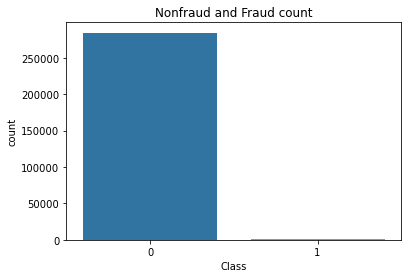

In [6]:
sns.countplot(df['Class'])
plt.title('Nonfraud and Fraud count')

**Findings:**  
- Amount is highly concentrated with <0.2% frauds

Text(0.5, 1.0, 'Median amount for Fraud and Nonfraud')

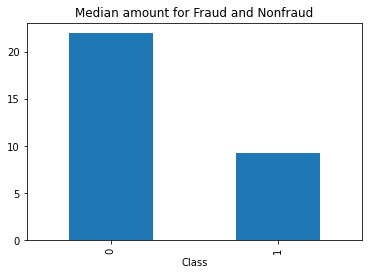

In [7]:
df.groupby('Class')['Amount'].median().plot.bar()
plt.title('Median amount for Fraud and Nonfraud')

#### 3.0.2 Amount analysis

<AxesSubplot:>

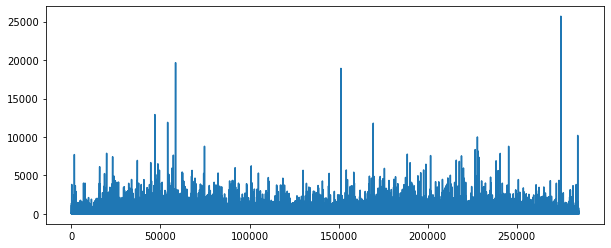

In [8]:
df['Amount'].plot(figsize = (10, 4))

In [9]:
print('The transaction peaks shows above: \n', df['Amount'].sort_values(ascending = False).head())

The transaction peaks shows above: 
 274771    25691.16
58465     19656.53
151296    18910.00
46841     12910.93
54018     11898.09
Name: Amount, dtype: float64


<AxesSubplot:>

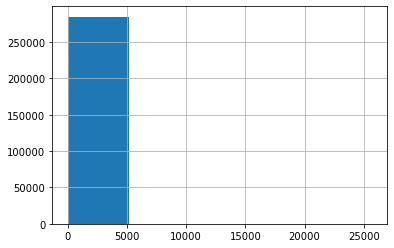

In [10]:
df['Amount'].hist(bins = 5)

In [11]:
print('Max of Amount: ', df['Amount'].max())
print('Min of Amount: ', df['Amount'].min())
print('Avg of Amount: ', df['Amount'].mean())

Max of Amount:  25691.16
Min of Amount:  0.0
Avg of Amount:  88.34961925087359


<AxesSubplot:ylabel='Amount'>

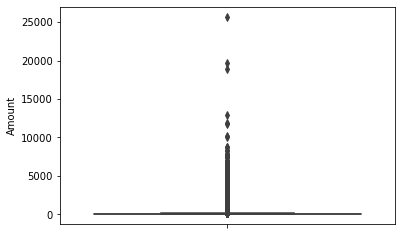

In [12]:
sns.boxplot(y = 'Amount', data = df)

Below review the distribution of outlier data distribution for each class

In [13]:
q1 = df['Amount'].quantile(0.25)
q3 = df['Amount'].quantile(0.75)
iqr = q3 + 1.5*q3

In [14]:
df_extreme = df[ df['Amount'] > iqr]

Findings:  
- median value for fraud and nonfraud is evenly balanced among extreme transactions

<AxesSubplot:xlabel='Class'>

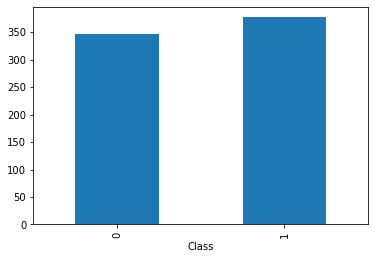

In [15]:
df_extreme.groupby('Class')['Amount'].median().plot.bar()

<AxesSubplot:>

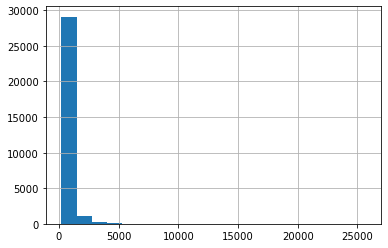

In [16]:
df_extreme['Amount'].hist(bins= 20)

**Findings:**  
 - Amount is highly skewed towards 0
 - no evidence shows extreme values is related to amount of transaction

#### 3.0.3 Time analysis

Text(0.5, 1.0, 'Distribution of Time')

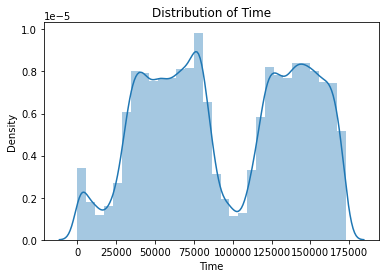

In [17]:
sns.distplot(df['Time'], bins = 30)
plt.title('Distribution of Time')

<AxesSubplot:xlabel='Class'>

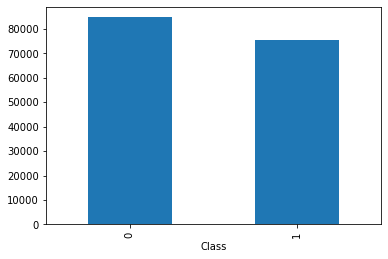

In [18]:
df.groupby('Class')['Time'].median().plot.bar()

<AxesSubplot:ylabel='Time'>

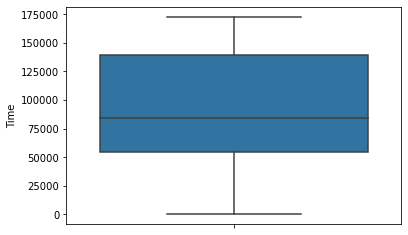

In [19]:
sns.boxplot(y = df['Time'])

**Findings:**
 - Transaction shows a m-shape with a valley near 100 000 
 - Fraud and non-fraud shows even median of transaction time

### 3.1 Scale data

given above boxplot: 
- use StandarScaler for Time
- use RobustScaler for Amount

In [20]:
std_scaler = StandardScaler()
df['Amount_scaled'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df.drop(['Amount'], inplace=True, axis = 1)

In [21]:
rob_scaler = RobustScaler()
df['Time_scaled'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time'], inplace=True, axis = 1)

### 3.2 Split data

In [22]:
y = df['Class']
X = df.drop(['Class'], axis = 1)

In [23]:
X.shape, y.shape

((284807, 30), (284807,))

In [24]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [26]:
# X_train.shape, X_test.shape

### 4. Random Forest modelling

#### 4.1 Grid search

In [27]:
parameter_grid = {'n_estimators': [80, 100, 120],
                 'max_depth': [5, 10, 15],
                 'max_features': [5, 6, 7]}
n_splits = 5
rf_model = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = RANDOM_STATE)

strat_cv = StratifiedKFold(n_splits = n_splits, random_state = RANDOM_STATE)

clf = GridSearchCV(estimator = rf_model, 
                   param_grid = parameter_grid, 
                   cv = strat_cv, 
                   scoring = 'recall', 
                   n_jobs = -1,
                  refit = True)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
clf.best_estimator_

In [ ]:
clf.best_score_

In [ ]:
clf.best_params_

In [ ]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(5)

In [ ]:
plt.figure( figsize = (10, 5) )
plt.plot(scores)
plt.plot(scores + std_error, 'b--')
plt.plot(scores - std_error, 'b--')
# alpha=0.2 controls the translucency of the fill color
plt.fill_between(range(0,27), scores + std_error, scores - std_error, alpha = 0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('Test')
plt.axhline(np.max(scores), linestyle='--', color='.5')

#### 4.2 Feature importance analysis

In [ ]:
var_importance = pd.Series(clf.best_estimator_.feature_importances_)
var_importance.index = X_train.columns
plt.figure( figsize = (10, 5) )
var_importance.sort_values(ascending = False).plot.bar()

#### Findings:
- Important features are: v17, v14, v12, v11, v10

#### 4.3 Evaluate model

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns = ['Prediction'])
y_pred_df.describe()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
cm = confusion_matrix(y_test, y_pred.round())
print(cm)

In [ ]:
plot_confusion_matrix(cm, classes = [0, 1], title = 'Confusion Matrix - Test dataset')

In [ ]:
print(classification_report(y_test, y_pred))

#### Findings:
- model shows a recall 0.76, slightly <0.78 on train set with minor overfitting